# MNIST Handwritten Digit Classification with PyTorch

## PyTorch Basics

- Tensor
- Autograd
- Transforms
- Neural Networks

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as functional
import numpy as np
import pandas as pd

np.random.seed(123)
torch.manual_seed(123)

from torchvision import transforms
from PIL import Image
from torch import tensor, eye

### Tensor

In mathematics, tensor is a multi-dimensional vector. We generally use 
[tensor rank](https://mathworld.wolfram.com/TensorRank.html) to describe tensors.

- Rank 0 tensor is a scalar
- Rank 1 tensor is a vector or array
- Rank 2 tensor is a matrix
- Rank 3+ tensor is a tensor


In Python, we can perform tensor calculation with `numpy`, `pytorch` or `tensorflow`. Since we are doing PyTorch, we can just focus on PyTorch version of tensors. In general PyTorch and TensorFlow tensors are better than `numpy` tensor because the data can be allocated on GPU whereas `numpy` can only go on CPU. However `numpy` is needed for a lot of libraries such as `matplotlib` for plotting data on graph.

For example,


$$
\begin{bmatrix}
 1 & 1 & 1 \\ 
 1 & 1 & 1 \\ 
 1 & 1 & 1
\end{bmatrix}
$$

is defined by

```py
tensor([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
], dtype=int)
```

In [2]:
mat_a = tensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]],dtype=int)
mat_b = tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]],dtype=int)
identity = eye(3, dtype=int)

$$
M_a \times M_b = \begin{bmatrix}
 1 & 1 & 1 \\ 
 1 & 1 & 1 \\ 
 1 & 1 & 1
\end{bmatrix} \begin{bmatrix}
 2 & 2 & 2 \\ 
 2 & 2 & 2 \\ 
 2 & 2 & 2
\end{bmatrix} = \begin{bmatrix}
 6 & 6 & 6 \\ 
 6 & 6 & 6 \\ 
 6 & 6 & 6
\end{bmatrix} 
$$

In [3]:
mat_a.matmul(mat_b)

tensor([[6, 6, 6],
        [6, 6, 6],
        [6, 6, 6]])

$$
M_a \times M_b = \begin{bmatrix}
 1 & 1 & 1 \\ 
 1 & 1 & 1 \\ 
 1 & 1 & 1
\end{bmatrix} \begin{bmatrix}
 1 & 0 & 0 \\ 
 0 & 1 & 0 \\ 
 0 & 0 & 1
\end{bmatrix} = \begin{bmatrix}
 1 & 1 & 1 \\ 
 1 & 1 & 1 \\ 
 1 & 1 & 1
\end{bmatrix} 
$$

In [4]:
mat_a.matmul(identity)

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])

PyTorch tensors support many operations, please refer to [PyTorch Tensor Tutorial](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html) to learn in depth about tensor operations.

### Autograd

Autograd is short for automatic gradient. Gradient is a vector of partial derivatives. Autograd performs partial derivatives in runtime on tensor operations. This is the foundational logic for all supervised machine learning algorithms.

Consider the following squared error equation, let $L$ denotes the squared loss.

$$
L(\vec{x}, \vec{y}, \vec{b}, M) = \Sigma_i\,(\vec{y} - M\vec{x} - \vec{b})^2
$$

What is the gradient of $L$? i.e. partial derivatives of $L$ with respect to $x$, $y$, $M$, and $b$? We can compute this quickly by hand.

$$
\nabla L = <\frac{\partial L}{\partial x}, \frac{\partial L}{\partial y}, \frac{\partial L}{\partial b}, \frac{\partial L}{\partial M}>
$$

$$
\frac{\partial L}{\partial x} = \Sigma_i\, 2 * (\vec{y} - M\vec{x} - \vec{b}) * (-M)
$$

$$
\frac{\partial L}{\partial y} = \Sigma_i\, 2 * (\vec{y} - M\vec{x} - \vec{b})
$$

$$
\frac{\partial L}{\partial b} = \Sigma_i\, 2 * (\vec{y} - M\vec{x} - \vec{b}) * (-1)
$$

$$
\frac{\partial L}{\partial M} = \Sigma_i\, 2 * (\vec{y} - M\vec{x} - \vec{b}) * (-\vec{x})
$$

We can also let PyTorch compute it for us.

In [5]:
x = tensor([
    [1],
    [1]
], dtype=float, requires_grad=True)
M = tensor([
    [2, 2],
    [2, 2],
], dtype=float, requires_grad=True)
b = tensor([
    [3],
    [3]
], dtype=float, requires_grad=True)
y = tensor([
    [4],
    [4]
], dtype=float, requires_grad=True)

L = torch.sum((y - M.matmul(x) - b)**2)

# Show the value of squared loss
print(L) 

# Use autograd to compute partial derivatives for all variables
L.backward() 
print(f"\nPartial derivatives of x = {x.grad}")
print(f"\nPartial derivatives of y = {y.grad}")
print(f"\nPartial derivatives of b = {b.grad}")
print(f"\nPartial derivatives of M = {M.grad}")

tensor(18., dtype=torch.float64, grad_fn=<SumBackward0>)

Partial derivatives of x = tensor([[24.],
        [24.]], dtype=torch.float64)

Partial derivatives of y = tensor([[-6.],
        [-6.]], dtype=torch.float64)

Partial derivatives of b = tensor([[6.],
        [6.]], dtype=torch.float64)

Partial derivatives of M = tensor([[6., 6.],
        [6., 6.]], dtype=torch.float64)


Autograd can perform very complicated partial derivative computation, please refer to [Autograd Tutorial](https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html) to learn more.

### Transforms

When we perform image classification, we need to resize the image, convert the image into a tensor representation, and preprocess the tensor. Here is an example.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Modified image dimension = torch.Size([3, 50, 50])
Modified image max = 1.0, min = -0.8039215803146362
Modified image standard deviation = 0.4606117606163025


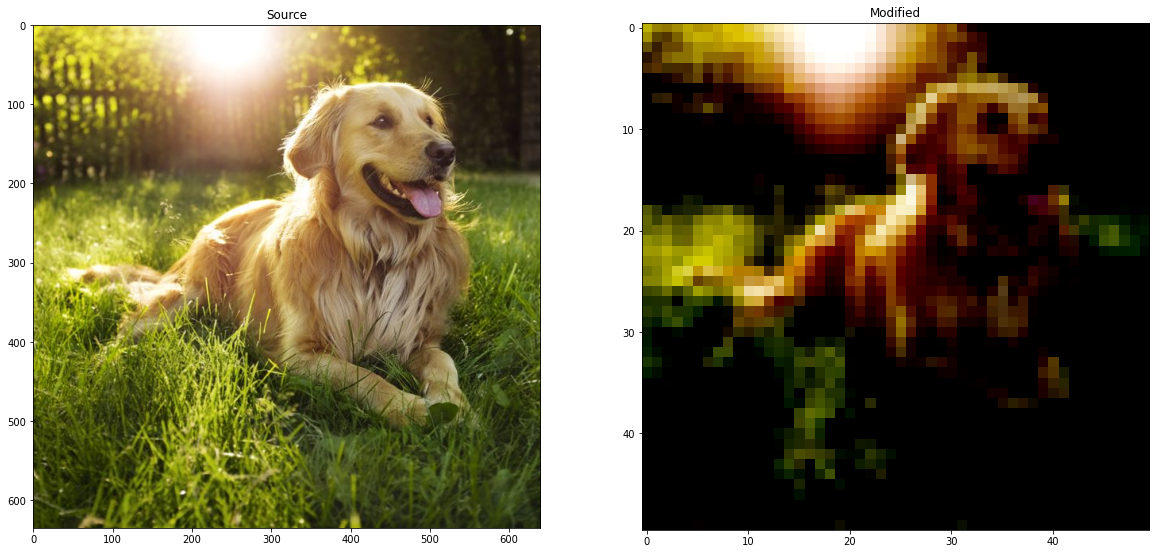

In [6]:
src_img = Image.open('img/dog.jpeg')

trans = transforms.Compose([
    # Make the image smaller 
    transforms.Resize((50, 50)), 
    # Convert it to a tensor
    transforms.ToTensor(), 
    # Normalize each RGB channel of an image such that channel's max and min value fall between -1 and 1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

mod_img = trans(src_img)
print(f"Modified image dimension = {mod_img.shape}")
print(f"Modified image max = {mod_img[0].max()}, min = {mod_img[0].min()}")
print(f"Modified image standard deviation = {mod_img[0].std()}")

# Visualize and compare the transformation
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(src_img)
axs[0].set_title('Source')
axs[1].imshow(mod_img.permute(1, 2, 0))
axs[1].set_title('Modified')
plt.show()

Why is transformation, particularly normalization, important? Short answer: it makes deep learning learns faster. However, the better answer can be found [here](https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258). To learn more about transformation, please refer to Torch Vision's transform [documentation](https://pytorch.org/vision/stable/transforms.html)

### Neural Networks

In the 2000s, we had linear/logistic regressions, decision trees (random forest), SVM, Bayesian networks, and etc for various machine learning tasks. By 2010s, all of them had been outperformed by neural network based deep learning architecture. This is especially true for natural language processing and computer vision tasks. Thus, all modern machine learning frameworks focus their implementation entirely on neural networks.

<img alt="Neural Networks" src="img/nn.png" width=500>

A neural network can be thought of as a chain of functions (they can be linear or non-linear). Let's look at a linear neural network that implements the following function.

$$
y = Mx + b
$$

### Linear Regression with Gradient Descent

[Gradient descent, how neural networks learn](https://www.youtube.com/watch?v=IHZwWFHWa-w&ab_channel=3Blue1Brown)

In [7]:
class Linear:
    def __init__(self):
        self.M = torch.randn(1, dtype=float, requires_grad=True)
        self.b = torch.randn(1, dtype=float, requires_grad=True)
    
    def forward(self, x):
        """Forward carries out the computation to produce an output
        
        Args:
            x (Tensor): input to the model
        """
        out = self.M * x # Linear operation 1
        out = out + self.b # Linear operation 2
        return out
    
    def gradient_descent(self, lr=0.001):
        """Performs gradient descent to update model parameters.
        
        Args:
            lr (float): learning rate determines how fast the network learns.
        """
        self.M.data -= lr * self.M.grad.data
        self.b.data -= lr * self.b.grad.data
         # Reset the gradient after it's been used
        self.M.grad.data.zero_()
        self.b.grad.data.zero_() 


model = Linear()

Let's generate some fake linear data for demonstration.

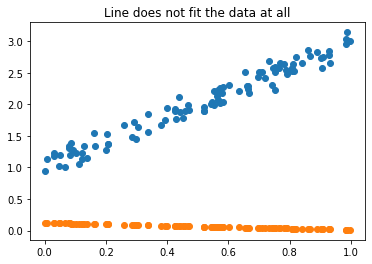

In [8]:
epsilon = (.1 * np.random.randn(100, 1))
true_b = 1
true_M = 2

# Training data to teach the linear model
x_train = np.random.rand(100, 1)
y_train = true_M * x_train + true_b + epsilon

# Convert numpy array into float tensor
x_tensor = tensor(x_train, dtype=float)
y_tensor = tensor(y_train, dtype=float)

# At first the model will perform poorly because it hasn't been traiend yet.
y_pred_tensor = model.forward(x_tensor)

plt.plot(x_train, y_train, 'o', x_train, y_pred_tensor.detach().numpy(), 'o')
plt.title('Line does not fit the data at all')
plt.show()

### Use Autograd to Train Model

The objective of training is to reduce errors. We can plot the errors over our training iteration. What we expect to see is a sharp drop of error values as training goes on.

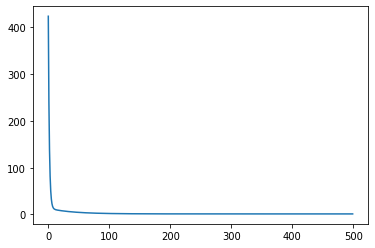

In [9]:
# Define an error function, also known as loss
def squared_loss(y, y_predict):
    loss_val = torch.sum((y - y_predict)**2)
    return loss_val 

# Perform training
losses = []
for _ in range(500):
    y_pred = model.forward(x_tensor) 
    loss = squared_loss(y_tensor, y_pred)
    losses.append(loss.item())
    loss.backward()
    model.gradient_descent(lr=0.001)
    
plt.plot(range(500), losses)

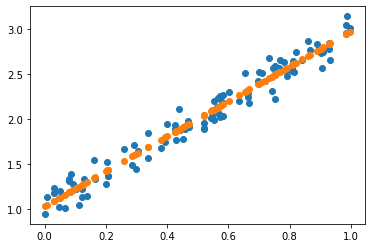

In [10]:
# Now the model has learned.
y_pred = model.forward(x_tensor)
plt.plot(x_train, y_train, 'o', x_train, y_pred.detach().numpy(), 'o')

In [11]:
# Check the parameters, they should be very close to the true value
print(model.M)
print(model.b)

tensor([1.9403], dtype=torch.float64, requires_grad=True)
tensor([1.0335], dtype=torch.float64, requires_grad=True)


### Better Version of Linear Neural Network

PyTorch provides neural network modules, loss functions and optimizer so we don't have to implement them ourselves. The following is identical to the implementation above.

In [12]:
class Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1, dtype=float)
        
    def forward(self, x):
        return self.linear(x)

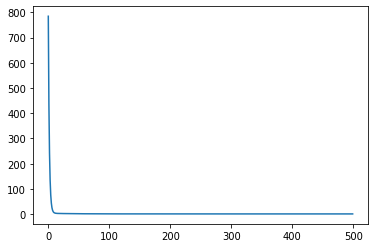

In [13]:
# Create a model with the new Linear class.
model = Linear()

# Sum up the mean squared loss, so it's the same loss from what we have above.
mean_squared_loss = nn.MSELoss(reduction='sum')

# Optimizer performs gradient descent automatically. SGD stands for
# stochastic gradient descent.
optimizer = optim.SGD(model.parameters(), lr=0.001)

losses = []
for _ in range(500):
    y_pred = model.forward(x_tensor)
    loss = mean_squared_loss(y_tensor, y_pred)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

plt.plot(range(500), losses)

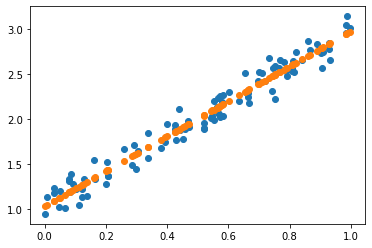

In [14]:
# Now the model has learned.
y_pred = model.forward(x_tensor)
plt.plot(x_train, y_train, 'o', x_train, y_pred.detach().numpy(), 'o')

## MNIST

### Dataset

MNIST is a large dataset of handwritten digits. The objective is to classify and convert these handwritten digit images into machine understandable integer. First, let's download the dataset and visualize them.

In [15]:
# Create transformation
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST('data/', train=True, download=True, transform=transform)
print(f"training dataset has {len(train_dataset)} examples")

test_dataset = torchvision.datasets.MNIST('data/', train=False, download=True, transform=transform)
print(f"test dataset has {len(test_dataset)} examples")

training dataset has 60000 examples
test dataset has 10000 examples


There are 2 sets of data. We will use the training dataset to train the model. The test dataset evaluates how well our model performs against new samples that the model hasn't seen before.

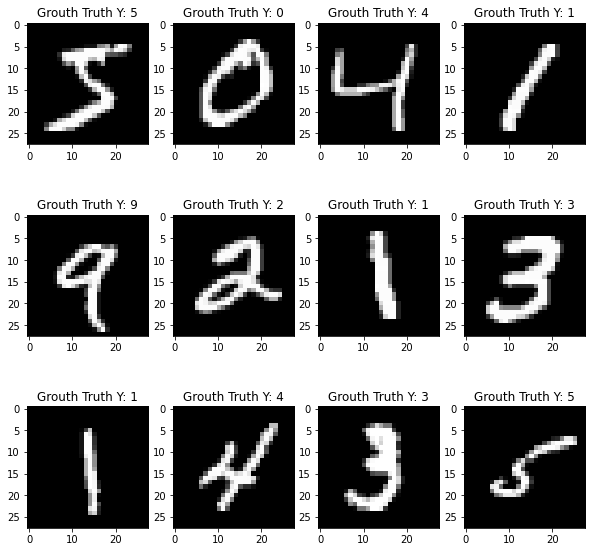

In [16]:
fig = plt.figure(figsize=(10, 10))
for i in range(12):
    x, y = train_dataset[i]
    plt.subplot(3, 4, i+1)
    plt.imshow(x.squeeze(0), cmap='gray')
    plt.title(f"Grouth Truth Y: {y}")

### Batch Data

Dataset need to be batched for performance reasons. Instead of feeding one image to the model at a time, we can feed `N` images at once. For convenience, we can use data loader to split data into batches.

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
for i, (x, y) in enumerate(train_loader):
    if i == 5:
        break
    print(f"batch {i} has x shape {x.shape} and y shape {y.shape}")

batch 0 has x shape torch.Size([32, 1, 28, 28]) and y shape torch.Size([32])
batch 1 has x shape torch.Size([32, 1, 28, 28]) and y shape torch.Size([32])
batch 2 has x shape torch.Size([32, 1, 28, 28]) and y shape torch.Size([32])
batch 3 has x shape torch.Size([32, 1, 28, 28]) and y shape torch.Size([32])
batch 4 has x shape torch.Size([32, 1, 28, 28]) and y shape torch.Size([32])


### Neural Network Modeling

When it comes to modeling, there are 2 important deciding factors

- Which model architecture to use for my dataset?
- Which loss function to optimize for?

The traditional architectural choice for image recognition is **convolutional neural networks**. We can compare the performance of a simple linear model to a convolutional model using the test dataset. Since we are performing classification, we will use **categorical cross entropy loss**.

- [A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)
- [Cross-Entropy Loss Function](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e)

In [18]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # We can stack many linear layers together to create a "network"
        self.layer_1 = nn.Linear(28*28, 100)
        self.layer_2 = nn.Linear(100, 100)
        self.layer_3 = nn.Linear(100, 10)
        # Use log softmax function convert numerical values into log(probabilities)
        # Why log(probabilities)? It helps with computing the cross entropy loss later.
        # We can easily convert it back to probabilities using exponential function.
        self.log_softmax = nn.LogSoftmax(dim=0)

    def forward(self, x):
        out = torch.flatten(x, 1) # Flatten the 28x28 image into a single dimensional vector
        out = self.layer_1(out)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.log_softmax(out)
        return out

In [19]:
model = LinearClassifier()
x, y = next(iter(train_loader)) 
y_pred = model(x)
probs = torch.exp(y_pred) # probability

indices = list(map(lambda i: f"sample {i}" , range(len(x))))

prob_df = pd.DataFrame(probs.detach().numpy(), index=indices)
print(prob_df.round(2).head())

print("\nPredicted classes for each sample\n")

class_df = prob_df.idxmax(axis=1)
print(class_df.head())

             0     1     2     3     4     5     6     7     8     9
sample 0  0.03  0.03  0.03  0.04  0.05  0.03  0.03  0.03  0.04  0.04
sample 1  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.02  0.02
sample 2  0.04  0.04  0.03  0.03  0.03  0.03  0.03  0.03  0.02  0.02
sample 3  0.04  0.03  0.03  0.03  0.03  0.03  0.03  0.02  0.04  0.04
sample 4  0.04  0.03  0.03  0.03  0.03  0.04  0.03  0.03  0.03  0.03

Predicted classes for each sample

sample 0    4
sample 1    5
sample 2    1
sample 3    8
sample 4    5
dtype: int64


In [20]:
class ConvClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # One layer is a stack of multiple units
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25))
        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.50))
        self.layer_3 = nn.Linear(1600, 128)
        self.layer_4 = nn.Linear(128, 10)
        self.log_softmax = nn.LogSoftmax(dim=0)
        
    def forward(self, x):
        out = self.layer_1(x) # Don't need to flatten the image because convolution works on 2D input.
        out = self.layer_2(out)
        out = torch.flatten(out, 1) # Flatten the convolutional outputs into a single dimensional vector
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.log_softmax(out)
        return out

In [21]:
model = ConvClassifier()
x, y = next(iter(train_loader)) 
y_pred = model(x)
probs = torch.exp(y_pred)

indices = list(map(lambda i: f"sample {i}" , range(len(x))))

prob_df = pd.DataFrame(probs.detach().numpy(), index=indices)
print(prob_df.round(2).head())

print("\nPredicted classes for each sample\n")

class_df = prob_df.idxmax(axis=1)
print(class_df.head())

             0     1     2     3     4     5     6     7     8     9
sample 0  0.03  0.03  0.02  0.03  0.04  0.03  0.04  0.03  0.03  0.04
sample 1  0.03  0.03  0.04  0.03  0.03  0.05  0.03  0.03  0.04  0.04
sample 2  0.03  0.03  0.03  0.03  0.02  0.02  0.03  0.02  0.04  0.02
sample 3  0.04  0.03  0.05  0.04  0.03  0.03  0.03  0.03  0.03  0.04
sample 4  0.03  0.04  0.03  0.04  0.03  0.02  0.03  0.02  0.02  0.02

Predicted classes for each sample

sample 0    4
sample 1    5
sample 2    8
sample 3    2
sample 4    1
dtype: int64


### Negative Log Loss

When [negative log loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html) is applied on [log softmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html), the end result is a [cross entropy loss](https://pytorch.org/docs/1.9.1/generated/torch.nn.CrossEntropyLoss.html). `CrossEntropyLoss` is a more optimized implementation by combining the two calculations into one step. For the purpose of demonstration, I have separated them into two function calls.



In [22]:
model = LinearClassifier()
x, y = next(iter(train_loader)) 
output = model(x)
loss = functional.nll_loss(output, y)
print(f"Linear classifier loss value: {loss.item()}")

Linear classifier loss value: 3.460362672805786


In [23]:
model = ConvClassifier()
x, y = next(iter(train_loader)) 
output = model(x)
loss = functional.nll_loss(output, y)
print(f"Convolutional classifier loss value: {loss.item()}")

Convolutional classifier loss value: 3.418074369430542


## Training

For every training step, we perform the following logic

- For every batch of training data
  - 1. Forward pass input data to model and generate an output.
  - 2. Compute loss using output and ground truth label.
  - 3. Use auotgrad to compute gradients, also known as `backward()` or backpropagation.
  - 4. Update the model parameters using optimizer.
  - 5. Reset the gradients.
- When training is completed on all batches of data, for every batch of test data
  - 1. Disable gradient for the following logic i.e. `with torch.no_grad()`
  - 2. Forward pass the input data to model and generate an output.
  - 3. Compute loss using output and ground truth label.
  - 4. Calculate accuracy of detection.

Then we repeat the training step `N` times known as `epochs`.

> If you have GPU, PyTorch will run computation on it.

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [25]:
def train(epoch, model, optimizer, train_loader, log_interval=100):
    model.train()
    losses = []
    for batch_i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = functional.nll_loss(output, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch_i % log_interval == 0:
            print((
                f"Training [epoch {epoch:02d}][{batch_i:04d}/{len(train_loader):04d}]"
                f"\tLoss {loss.item():.6f}"
            ))
    return np.average(losses)


def test(epoch, model, test_loader):
    model.eval()
    losses = []
    num_correct_preds = 0
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = functional.nll_loss(output, y)
            losses.append(loss.item()) 
            # Convert probabilities into prediction, pick the most probable class.
            pred = output.argmax(dim=1, keepdim=True)
            # Convert target into a one-hot representation, then compare match rate.
            num_correct_preds += pred.eq(y.view_as(pred)).sum().item()
    print((
        f"Testing [epoch {epoch:02d}] Average Loss: {np.average(losses)}"
        f"\tAccuracy {100.0 * num_correct_preds / len(test_loader.dataset):0.2f}%"
    ))

Now define our models and optimizers. We need to send our model to device, i.e. send it to a CPU or GPU. The learning rate for optimizers is a **hyperparameter**. We need to run experimentation to find the best value.

In [26]:
linear_model = LinearClassifier().to(device)
linear_optim = optim.SGD(linear_model.parameters(), lr=0.01)

In [27]:
conv_model = ConvClassifier().to(device)
conv_optim = optim.SGD(conv_model.parameters(), lr=0.1)

Before training, our model should have a 10% accuracy which means it is randomly guessing a number from 0 to 9.

In [28]:
test(0, linear_model, test_loader)
test(0, conv_model, test_loader)

Testing [epoch 00] Average Loss: 3.4750767249268844	Accuracy 10.57%
Testing [epoch 00] Average Loss: 3.463904187321282	Accuracy 11.01%


### Train Linear Model

In [29]:
num_epochs = 10 # We will train it for 10 epochs, 10 training/testing steps.
log_interval = 375 # We log once every 1000 batches have processed.

In [30]:
epoch_losses = []
for epoch in range(1, num_epochs+1):
    epoch_losses.append(train(epoch, linear_model, linear_optim, train_loader,
                              log_interval=log_interval))
    test(epoch, linear_model, test_loader)

Training [epoch 01][0000/1875]	Loss 3.449574
Training [epoch 01][0375/1875]	Loss 1.930444
Training [epoch 01][0750/1875]	Loss 1.782594
Training [epoch 01][1125/1875]	Loss 1.949899
Training [epoch 01][1500/1875]	Loss 1.776312
Testing [epoch 01] Average Loss: 1.8588090876039987	Accuracy 85.75%
Training [epoch 02][0000/1875]	Loss 1.768950
Training [epoch 02][0375/1875]	Loss 1.769545
Training [epoch 02][0750/1875]	Loss 1.698700
Training [epoch 02][1125/1875]	Loss 1.853343
Training [epoch 02][1500/1875]	Loss 1.769654
Testing [epoch 02] Average Loss: 1.8413355221001866	Accuracy 86.34%
Training [epoch 03][0000/1875]	Loss 1.757152
Training [epoch 03][0375/1875]	Loss 1.755067
Training [epoch 03][0750/1875]	Loss 1.673425
Training [epoch 03][1125/1875]	Loss 1.832921
Training [epoch 03][1500/1875]	Loss 1.756167
Testing [epoch 03] Average Loss: 1.8353053506570882	Accuracy 86.28%
Training [epoch 04][0000/1875]	Loss 1.748515
Training [epoch 04][0375/1875]	Loss 1.751012
Training [epoch 04][0750/1875]	

Text(0.5, 1.0, 'Loss over Epoch')

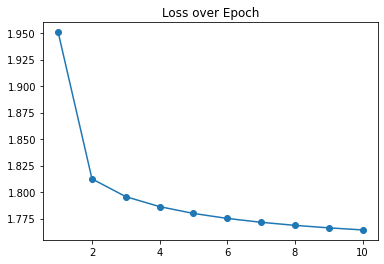

In [31]:
plt.plot(range(1, num_epochs+1), epoch_losses, '-o')
plt.title('Loss over Epoch')

### Train Convolutional Model

In [32]:
epoch_losses = []
for epoch in range(1, num_epochs+1):
    epoch_losses.append(train(epoch, conv_model, conv_optim, train_loader,
                              log_interval=log_interval))
    test(epoch, conv_model, test_loader)

Training [epoch 01][0000/1875]	Loss 3.479684
Training [epoch 01][0375/1875]	Loss 1.719224
Training [epoch 01][0750/1875]	Loss 1.544390
Training [epoch 01][1125/1875]	Loss 1.601568
Training [epoch 01][1500/1875]	Loss 1.614626
Testing [epoch 01] Average Loss: 1.5139132799051058	Accuracy 95.60%
Training [epoch 02][0000/1875]	Loss 1.497247
Training [epoch 02][0375/1875]	Loss 1.450122
Training [epoch 02][0750/1875]	Loss 1.434823
Training [epoch 02][1125/1875]	Loss 1.515927
Training [epoch 02][1500/1875]	Loss 1.557704
Testing [epoch 02] Average Loss: 1.4806470417747863	Accuracy 96.19%
Training [epoch 03][0000/1875]	Loss 1.461701
Training [epoch 03][0375/1875]	Loss 1.505005
Training [epoch 03][0750/1875]	Loss 1.387259
Training [epoch 03][1125/1875]	Loss 1.442263
Training [epoch 03][1500/1875]	Loss 1.552193
Testing [epoch 03] Average Loss: 1.4555156404217973	Accuracy 96.57%
Training [epoch 04][0000/1875]	Loss 1.412632
Training [epoch 04][0375/1875]	Loss 1.442438
Training [epoch 04][0750/1875]	

Text(0.5, 1.0, 'Loss over Epoch')

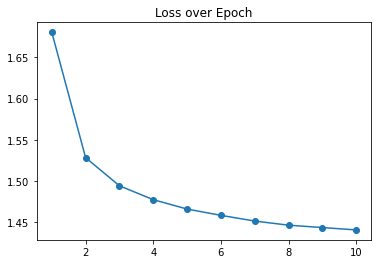

In [33]:
plt.plot(range(1, num_epochs+1), epoch_losses, '-o')
plt.title('Loss over Epoch')

We can play around with different

- model architecture
- batch size e.g. 8, 16, 32, 64
- [optimizer](https://pytorch.org/docs/stable/optim.html) e.g. SGD, Adam, Adagrad 
- learning rate e.g. 0.001, 0.01, 0.1, 1.0

to achieve a higher accuracy.

## Evaluation

Let's visualize what is the model predicting.

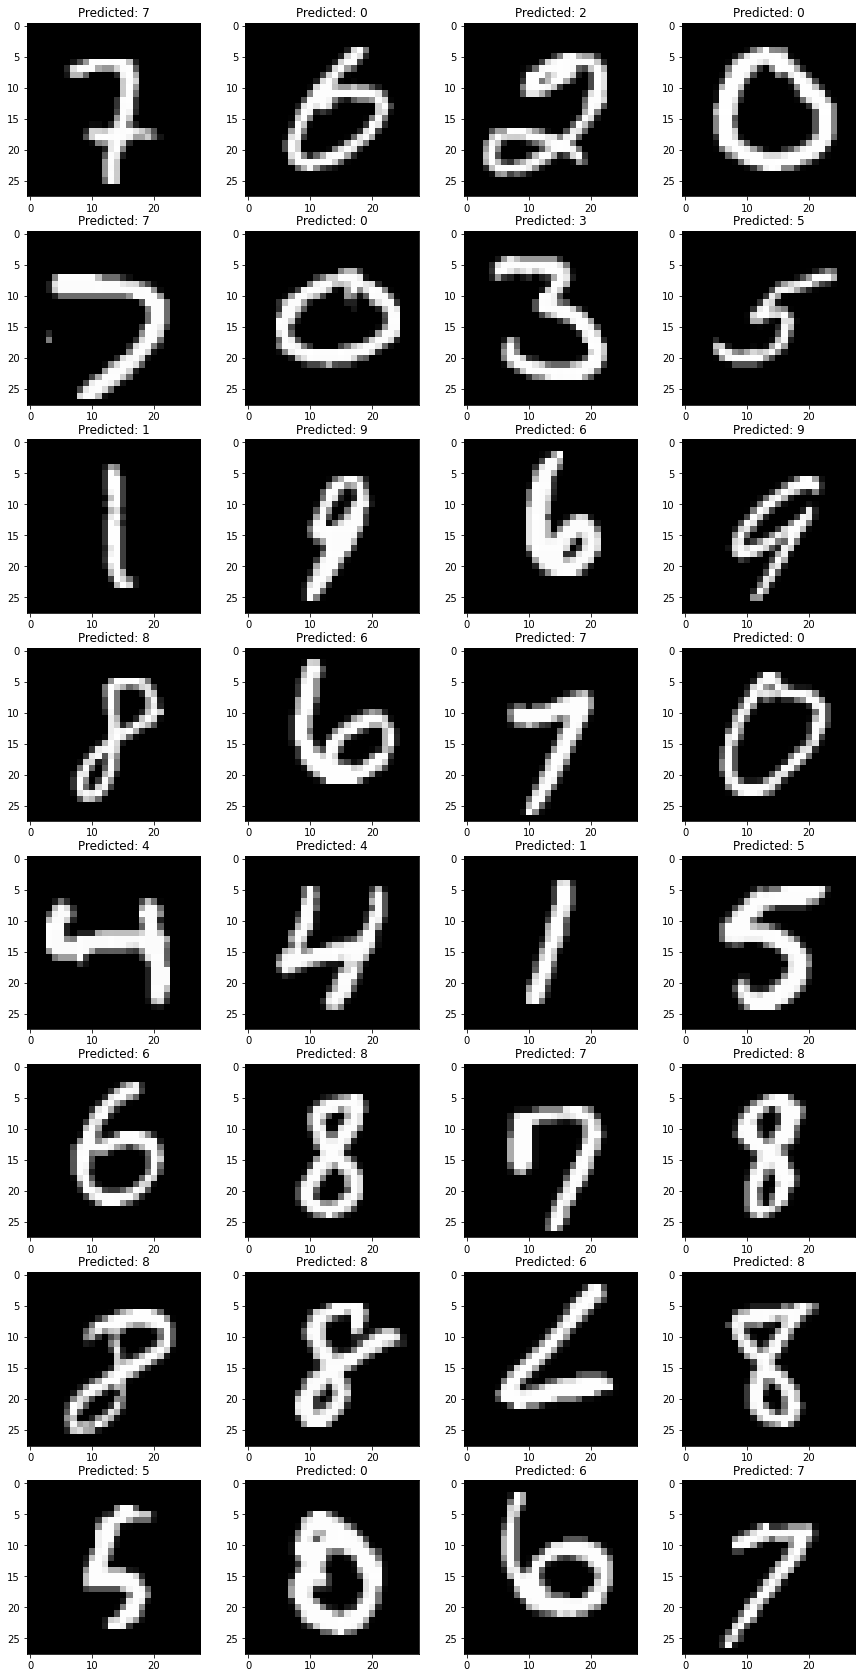

In [34]:
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)
output = conv_model(x)
pred = output.argmax(dim=1, keepdim=True)

fig = plt.figure(figsize=(15, 30))
for i in range(len(x)):
    plt.subplot(8, 4, i+1)
    plt.imshow(x[i].detach().cpu().numpy().squeeze(0), cmap='gray')
    plt.title(f"Predicted: {pred[i].item()}")
# plt.tight_layout()
plt.show()